In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
from scipy.ndimage import gaussian_filter
import math

In [4]:
class FactorizedLinear(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(FactorizedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.k = k

        self.U = nn.Parameter(torch.Tensor(k, in_features))
        self.V = nn.Parameter(torch.Tensor(out_features, k))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.U, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.V, a=math.sqrt(5))

    def forward(self, input):
        return torch.mm(self.V, torch.mm(self.U, input.t())).t()


In [5]:
class Net(nn.Module):
    def __init__(self, k):
        super(Net, self).__init__()
        self.fc1 = FactorizedLinear(784, 128, k)
        self.fc2 = FactorizedLinear(128, 64, k)
        self.fc3 = FactorizedLinear(64, 10, k)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
k = 10

In [8]:
model = Net(k)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
# Train the model
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

Training loss: 1.6190576436423034
Training loss: 0.5691927246161615
Training loss: 0.3703682310720369
Training loss: 0.30736342752411927
Training loss: 0.2717337008954874


In [10]:
# Test the model
correct_count, all_count = 0, 0
for images,labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", 100*(correct_count/all_count), "%")

Number Of Images Tested = 10000

Model Accuracy = 92.29 %


## Results

For the standard model, the number of parameters are as follows

| Input | FC1 | FC2 |
|-------|-----|-----|
| 784   | 128 | 128 |

So the number of parameters will be $784\times128+128=100,480$ for the first layer, and $128\times64+64=8,256$ for the second layer. Total number of parameters = $108,736$

For the factorized mode, with $k=10$ we have the following:
$784\times10+10\times128+128 = 9,248$. Similarly for the second layer, it would be $128\times10+10\times64+64=1,856$. Total parameters = $11,104$

Parameter difference = $(108736 - 11,104) = 97632$
Reduction in computation = $(\frac{97632}{108736})\times100 \approx 90\%$ reduction


## Question is, For a similar model of hidden layer size 15 and 14 respectively, what is the number of parameters and corresponding accuracy?

In [23]:
class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.fc1 = nn.Linear(784, 15) # Hidden layer size 15 and 14 is approximately same 
        self.fc2 = nn.Linear(15, 14)  # no of parameters as the factorized layers i.e about 12k
        self.fc3 = nn.Linear(14, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

new_model = Net_new()
new_criterion = nn.CrossEntropyLoss()
new_optimizer = optim.SGD(new_model.parameters(), lr=0.01)

# Train the new model
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        new_optimizer.zero_grad()
        
        output = new_model(images)
        loss = new_criterion(output, labels)
        loss.backward()
        new_optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

# Test the new model
correct_count, all_count = 0, 0
for images,labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = new_model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", 100*(correct_count/all_count), "%")

Training loss: 0.9994386468551306
Training loss: 0.3992272469757208
Training loss: 0.3295346940917247
Training loss: 0.29452726823974773
Training loss: 0.26954435935216164
Number Of Images Tested = 10000

Model Accuracy = 92.29 %


In [26]:
# For M
class Net_original(nn.Module):
    def __init__(self):
        super(Net_original, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.f

original_model = Net_original()

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The factorized model has {count_parameters(model):,} parameters')
print(f'The new model has {count_parameters(new_model):,} parameters')
print(f"The original model has {count_parameters(original_model):,} parameters")

The factorized model has 11,780 parameters
The new model has 12,149 parameters
The original model has 109,386 parameters


#### $\frac{Accuracy}{Number of parameters}$

In [36]:
x1 = 92.29/count_parameters(model) *10e4

In [37]:
x2 = 92.29/count_parameters(new_model) *10e4

In [39]:
x1

783.4465195246181

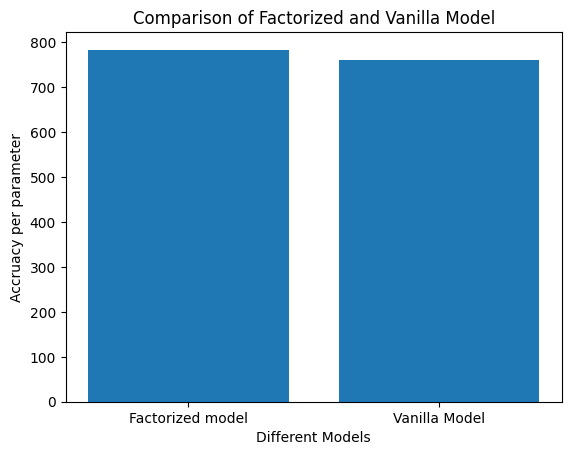

In [45]:
import matplotlib.pyplot as plt

x_values = ['Factorized model', 'Vanilla Model']
y_values = [x1, x2]

plt.bar(x_values, y_values)
plt.xlabel('Different Models')
plt.ylabel('Accruacy per parameter')
plt.title('Comparison of Factorized and Vanilla Model')
plt.show()